# Tracker Demonstration

This notebook demonstrates vehicles [**tracking**](#Apply-Tracking) for **a single 8-minute-video**, shows various [**properties of the tracking**](#Explanatory-Descriptive-Analysis), studies some [**anomalies**](#Invalid-Trackings-Study) in the tracks (intended to better understand the detection & tracking algorithms rather than the actual behavior of vehicles), and briefly studies the [**driving speed**](#Driving-Speed-Analysis) of the cars along the video.

- [**Tracking**](#Apply-Tracking)
- [**Explanatory Descriptive Analysis**](#Explanatory-Descriptive-Analysis)
- [**Anomalies Study**](#Invalid-Trackings-Study)
- [**Driving Speed Analysis**](#Driving-Speed-Analysis)
- [**Summary**](#Summary)

## Configuration

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, sys, time, datetime, random
from pathlib import Path
from warnings import warn
from tqdm import tqdm, tnrange, tqdm_notebook
import pickle as pkl
import gc

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
import cv2
from PIL import Image
from IPython.display import clear_output

import Tracker as t

In [3]:
if '../Detector' not in sys.path: sys.path.append('../Detector')
import DetectorNetwork as dn

In [5]:
# Configuration

SAVE_MODE = True

VIDEO = '20190520_105429'
# '20190616_085753'
# videopath = str(DATA/'20190622_124116.mp4') # bad detection
# videopath = str(DATA/'20190703_163050_slipping_protest.2.mp4') # fast
# videopath = str(DATA/'20190612_175832.mp4') # slow

CROP = True
FRAME_CONSTRAINTS_LEVEL = 2
MAX_FRAMES = np.Inf

FPS = 30/8
W, H = 1920, 1080

DETECTOR = '../detector/models/model_15images.mdl'

In [6]:
# Initialization

VIDEOS_DIR = Path(r'D:\Media\Videos\Ayalon')
VIDEO_PATH = str(VIDEOS_DIR/(VIDEO+'.mp4'))

if CROP:
    FRAME_AREA = (0,1050,450,900) if VIDEO<'20190525_2000' else \
                 (0,1000,240,480) if VIDEO<'20190526_1200' else (0,1000,600,1080) # x1,x2,y1,y2
else:
    FRAME_AREA = None

## Apply Tracking

In [11]:
model = t.get_detector(FRAME_AREA, constraints_level=FRAME_CONSTRAINTS_LEVEL, detect_thresh=0.3, verbose=0)

In [7]:
if SAVE_MODE:
    X, Y, S, N = t.process_video(model, VIDEO_PATH, area=FRAME_AREA, max_frames=MAX_FRAMES, meters=False,
                                 display=0, title='', to_save=True, verbose=2)
    df = t.summarize_video(X, Y, S, os.path.basename(VIDEO_PATH), FRAME_AREA[1]-FRAME_AREA[0], FRAME_AREA[3]-FRAME_AREA[2],
                           FPS=FPS, to_save=True, verbose=True)
    
else:
    with open(f'track_data/{VIDEO:s}.pkl','rb') as f:
        df = pkl.load(f)
        X = df['X']
        Y = df['Y']
        S = df['S']
        N = df['N']
    df = pd.read_csv(f'track_data/{VIDEO:s}.csv', index_col='car')
    df.index = [str(i) for i in df.index]

In [8]:
n_frames = len(N)
total_time = n_frames / FPS
slope = t.get_cars_direction(df)

In [9]:
print(df.columns)
df.head()

Index(['video', 'vid_len', 'date', 'time', 'weekday', 'n_shots',
       'consistent_xy_nas', 'continuous_track', 'avg_size', 'max_size',
       'valid_size', 'neg_x_motion', 'neg_y_motion', 'valid_x_dir',
       'valid_y_dir', 'min_x', 'max_x', 'min_y', 'max_y', 't0', 'dt', 'dx',
       'dy', 'x_path_rel', 'y_path_rel', 'long_path', 'v', 'abs_v',
       'road_perpendicularity', 'perpendicular_range'],
      dtype='object')


video   vid_len      date       time  weekday  n_shots  \
20  20190520_105429.mp4  7.231111  20190520  10.908056        2        1   
19  20190520_105429.mp4  7.231111  20190520  10.908056        2       32   
18  20190520_105429.mp4  7.231111  20190520  10.908056        2       42   
17  20190520_105429.mp4  7.231111  20190520  10.908056        2       16   
16  20190520_105429.mp4  7.231111  20190520  10.908056        2       11   

    consistent_xy_nas  continuous_track   avg_size   max_size  \
20               True              True  51.135514  51.135514   
19               True              True  55.712109  65.944960   
18               True              True  47.930300  59.719375   
17               True             False  65.019961  69.306466   
16               True             False  42.830696  55.498324   

           ...                  dt          dx          dy  x_path_rel  \
20         ...            0.000000    0.000000    0.000000    0.000000   
19         ...            8.266667  800.981380  136.196714    0.762839   
18         ...           10.933333  889.551560  150.426875    0.847192   
17         ...            4.800000  678.984593  115.915210    0.646652   
16         ...            3.733333  533.062819  146.744572    0.507679   

    y_path_rel  long_path           v       abs_v  road_perpendicularity  \
20    0.000000      False         NaN         NaN              57.444829   
19    0.302659       True   98.283645   98.602257              73.294524   
18    0.334282       True   82.516538   82.718964              55.152311   
17    0.257589       True  143.501659  143.593966             105.456593   
16    0.326099       True  148.096162  148.715387              94.445023   

    perpendicular_range  
20             0.000000  
19            14.986906  
18            15.335702  
17             6.546759  
16            55.235087  

[5 rows x 30 columns]

In [10]:
gc.collect()

77

## Explanatory Descriptive Analysis

In [9]:
mpl.rcParams.update({'font.size': 13})

#### Play a sample of the video

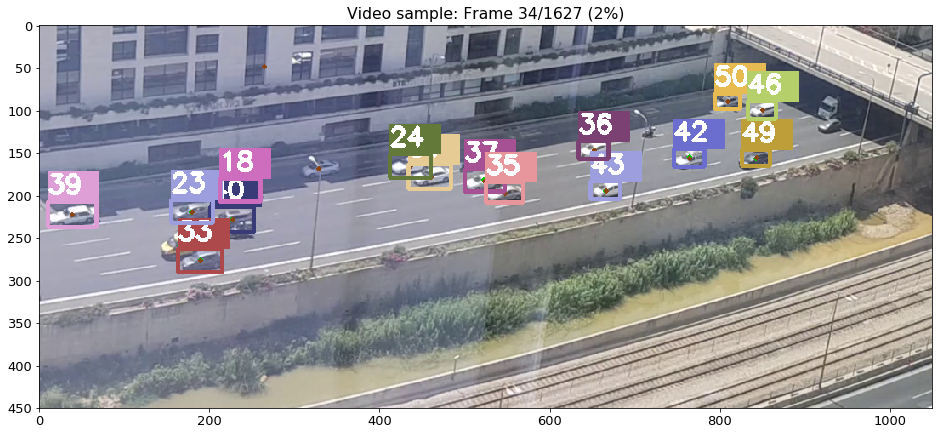

In [12]:
t.visualize_video(model, VIDEO_PATH, X, Y, car=X.columns[10], frame0=5, area=FRAME_AREA, min_hits=1,
                 boxes=True, dots=False, all_active_tracks=True, all_detections=True, self_track=3, extra_frames=15,
                 display=2, save_frame=None, save_video=None, title='Video sample', verbose=True, show_scores=False)

#### Show all trackings

Wall time: 769 ms


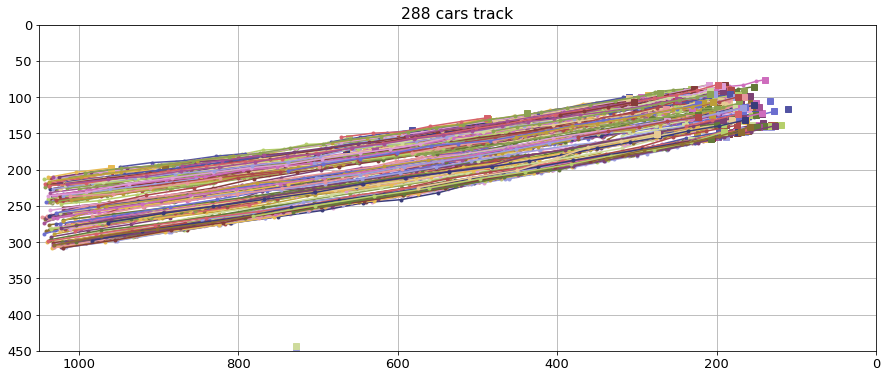

In [13]:
%%time

plt.figure(figsize=(15,6))
plt.title(f'{X.shape[1]:d} cars track')
t.set_track_figure(FRAME_AREA)

for car in X.columns:
    t.plot_track(X,Y,car)

#### Show distributions of data columns

In [14]:
variables_to_ignore = ('video', 'vid_len', 'date', 'time', 'weekday')

variables_groups_to_compare = (
    ('consistent_xy_nas','valid_size','valid_x_dir','valid_y_dir', 'continuous_track','long_path'),
    ('min_x','max_x'),
    ('min_y','max_y'),
    ('avg_size','max_size'),
    ('v','abs_v'),
)

binary_variables = (0,)

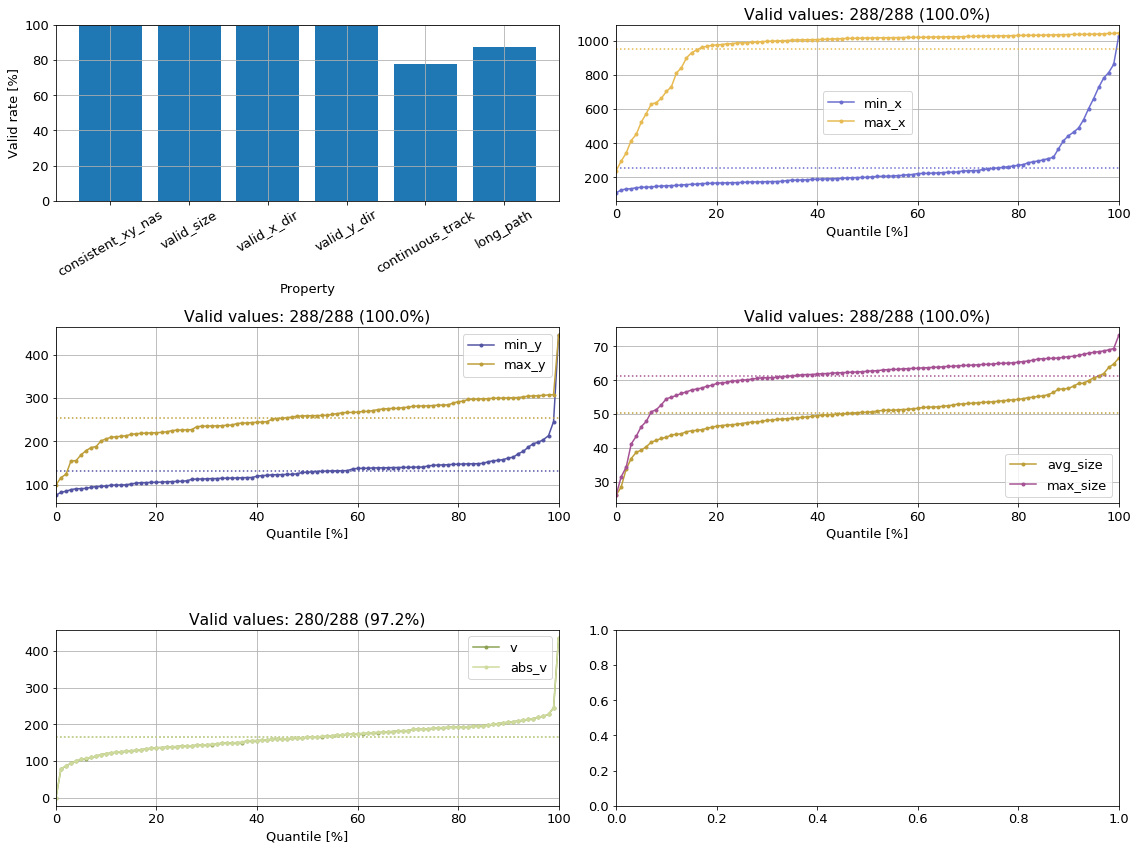

In [34]:
n_rows = int(np.ceil(5/2))
_, axs = plt.subplots(n_rows, 2, figsize=(16,n_rows*4))

for i, cols in enumerate(variables_groups_to_compare):
    ax = plt.subplot(n_rows, 2, i+1)
    if i in binary_variables:
        ax.bar(cols, [100*np.mean(df[col]) for col in cols])
        ax.set_ylim((0,100))
        ax.set_xlabel('Property')
        ax.set_ylabel('Valid rate [%]')
        ax.tick_params(axis='x', rotation=30)
        ax.grid()
    else:
        t.qplots(df.loc[:,cols])

plt.tight_layout()

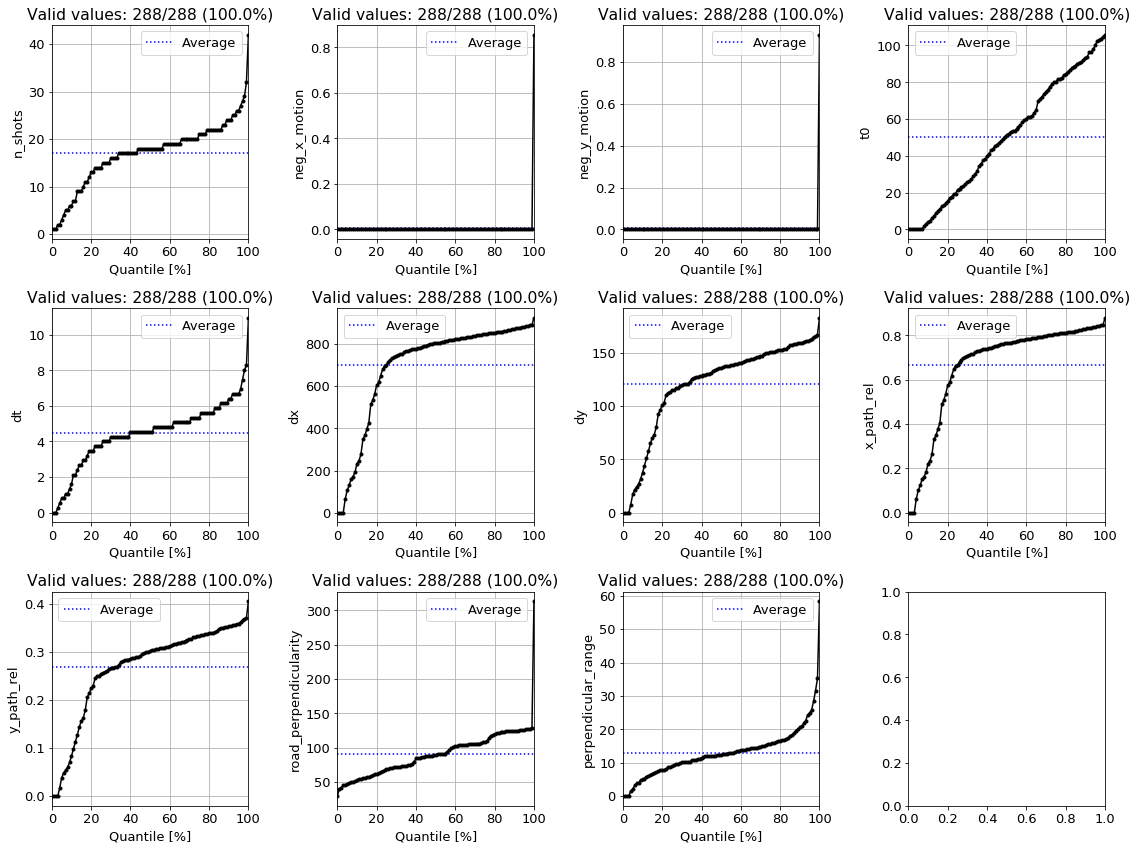

In [16]:
cols = [col for col in df.columns if not col in
        [c for grp in variables_groups_to_compare for c in grp] + list(variables_to_ignore)]
n_rows = int(np.ceil(len(cols)/4))
_, axs = plt.subplots(n_rows, 4, figsize=(16,n_rows*4))

for i,c in enumerate(cols):
    ax = plt.subplot(n_rows, 4, i+1)
    if type(df[c][0]) is str:
        df[c].value_counts().plot('bar')
        ax.set_xlabel(c)
        ax.set_ylabel('Count')
        ax.grid()
    else:
        t.qplot(df[c], ax=ax, ylab=c, logscale=False)

plt.tight_layout()

#### Show relations between a few pairs of columns

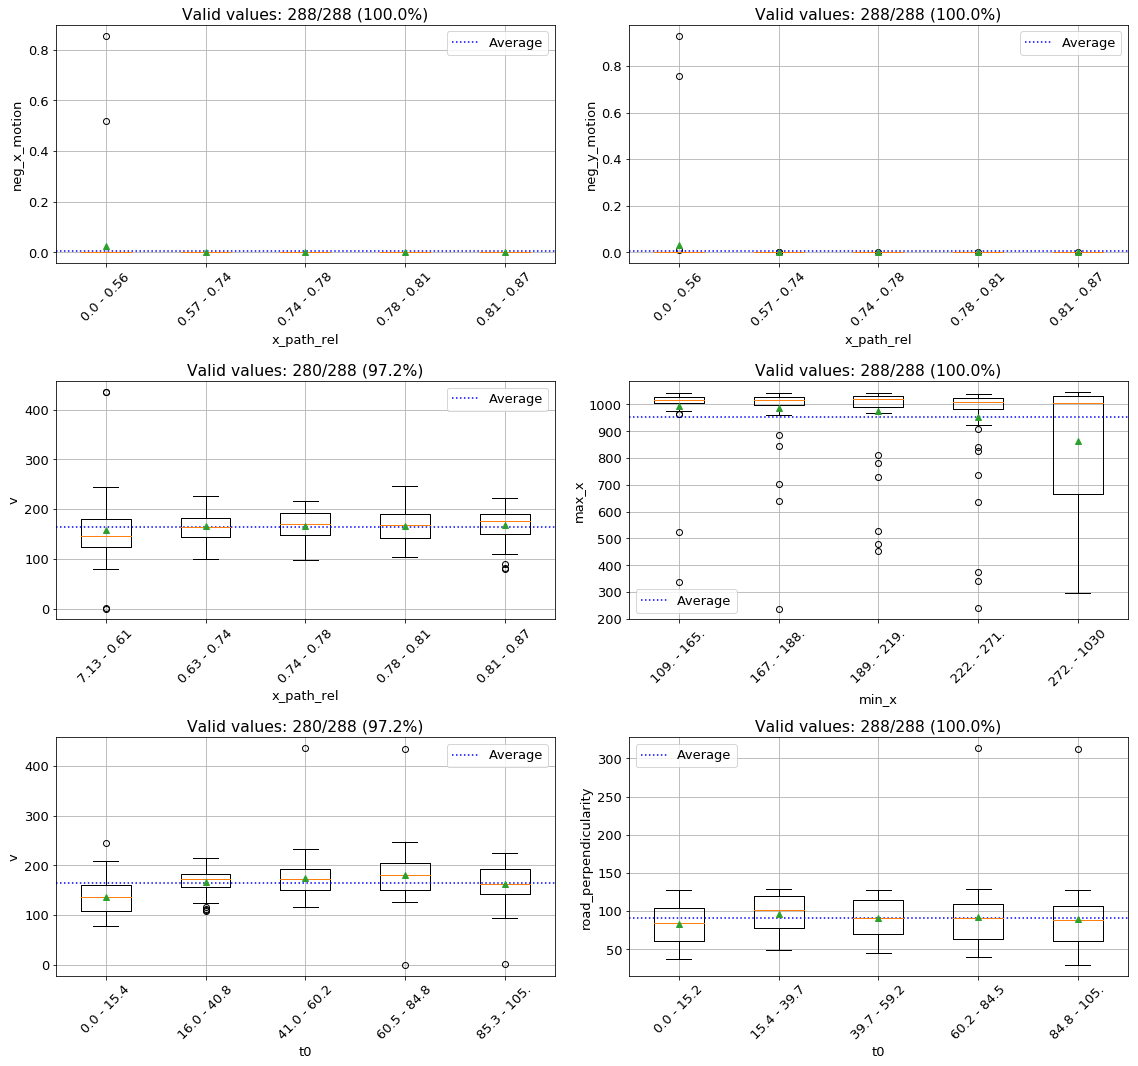

In [17]:
pairs = (
    ('x_path_rel','neg_x_motion'),
    ('x_path_rel','neg_y_motion'),
    ('x_path_rel','v'),
    ('min_x','max_x'),
    ('t0','v'),
    ('t0','road_perpendicularity'),
)

n_rows = int(np.ceil(len(pairs)/2))
_, axs = plt.subplots(n_rows, 2, figsize=(16,n_rows*5))

for i,(c1,c2) in enumerate(pairs):
    ax = plt.subplot(n_rows, 2, i+1)
    t.boxplot_per_bucket(df[c1], df[c2], ax=ax, xlab=c1, ylab=c2, logscale=False)

plt.tight_layout()

## Invalid Trackings Study

Total number of detections:	4913
Number of frames:	400
Number of detected cars:	288
Total detections inconsistency:	0
Detections per car:	17.1
Detections per frame:	12.3
Skipped car-frames:	175 (0.6 per car, 0.4 per frame)
Cars untracked:	29 (0.1 per frame)


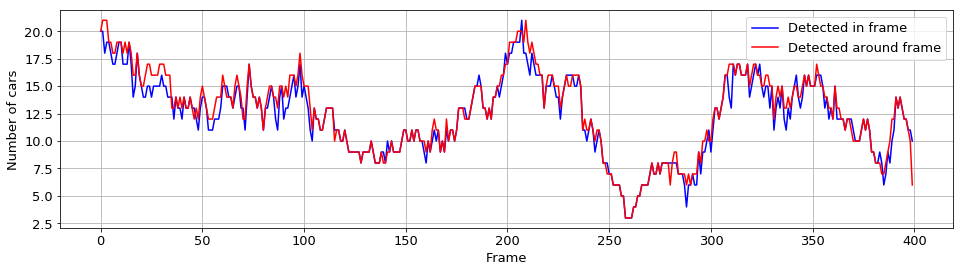

In [18]:
t.cars_per_frame_sanity(df, N);

Valid fields:  consistent_xy_nas, valid_size

valid_x_dir overlaps (all=2):
{'valid_y_dir': 2, 'long_path': 2, 'continuous_track': 0}

valid_y_dir overlaps (all=2):
{'valid_x_dir': 2, 'long_path': 2, 'continuous_track': 0}

long_path overlaps (all=36):
{'valid_x_dir': 2, 'valid_y_dir': 2, 'continuous_track': 4}

continuous_track overlaps (all=64):
{'valid_x_dir': 0, 'valid_y_dir': 0, 'long_path': 4}


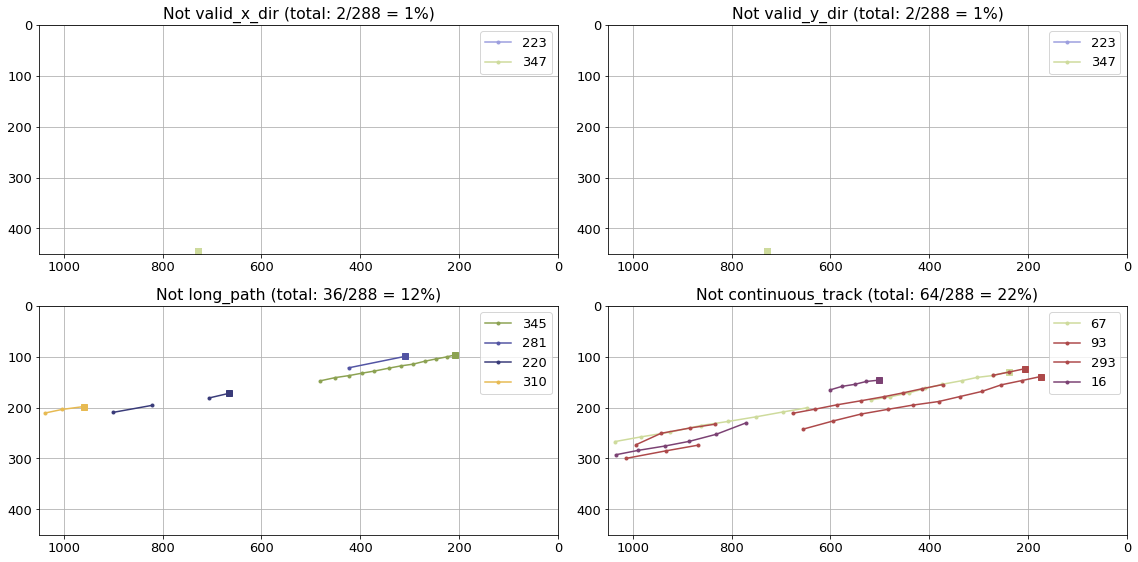

In [19]:
validations = ('consistent_xy_nas','valid_x_dir','valid_y_dir','valid_size','long_path','continuous_track')
n_samples = 4

all_valid = [val for val in validations if df[val].all()]
print('Valid fields: ', ', '.join(all_valid))

validations = [val for val in validations if val not in all_valid]
n_rows = int(np.ceil(len(validations)/2))
_, axs = plt.subplots(n_rows, 2, figsize=(16,n_rows*4))

bad_car = {}
for i,val in enumerate(validations):
    ax = plt.subplot(n_rows, 2, i+1)
    t.set_track_figure(FRAME_AREA, ax=ax)
    
    cars = df.index[np.logical_not(df[val])]
    n_bad = len(cars)
    if n_samples < len(cars):
        cars = np.random.choice(cars, n_samples, replace=False, p=df.x_path_rel[cars]/np.sum(df.x_path_rel[cars]))
    
    bad_car[val] = cars[0]
    
    for car in cars:
        t.plot_track(X,Y,car,ax)
    ax.set_title(f'Not {val:s} (total: {n_bad:d}/{df.shape[0]:d} = {100*n_bad/df.shape[0]:.0f}%)')
    ax.legend()
    
    print(f'\n{val:s} overlaps (all={np.sum(np.logical_not(df[val])):d}):')
    print({val2: np.sum(np.logical_not(df.loc[np.logical_not(df[val]),val2])) for val2 in validations if val2!=val})

plt.tight_layout()

Short path:

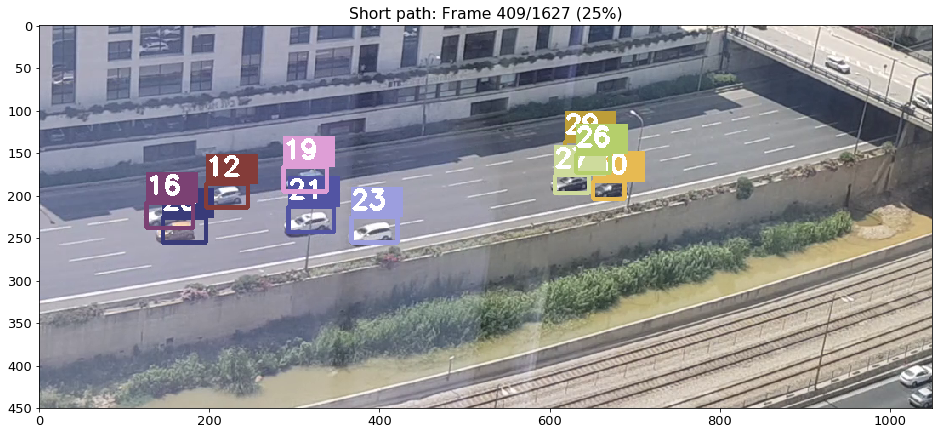

In [36]:
val = 'long_path'
if val in bad_car:
    car = bad_car[val]
    t.visualize_video(model, VIDEO_PATH, X, Y, car=car, frame0=None, area=FRAME_AREA,
                   boxes=False, dots=True, all_active_tracks=False, all_detections=False, self_track=5, extra_frames=5,
                   display=2, save_frame=None, save_video=None, title='Short path')

Negative motion along x-axis:

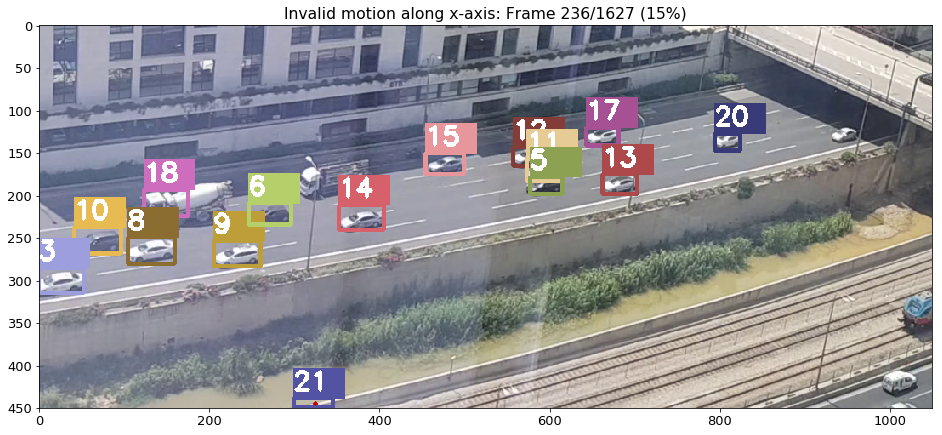

In [21]:
val = 'valid_x_dir'
if val in bad_car:
    car = bad_car[val]
    t.visualize_video(model, VIDEO_PATH, X, Y, car=car, frame0=None, area=FRAME_AREA,
                   boxes=False, dots=True, all_active_tracks=False, all_detections=False, self_track=3, extra_frames=0,
                   display=2, save_frame=None, save_video=None, title='Invalid motion along x-axis')
    # save: OUT_PATH/'neg_x'

Negative motion along y-axis:

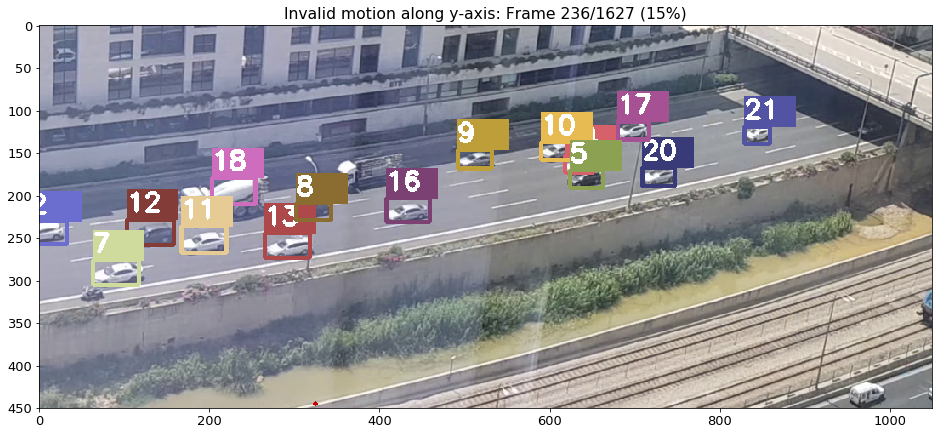

In [94]:
val = 'valid_y_dir'
if val in bad_car:
    car = bad_car[val]
    t.visualize_video(model, VIDEO_PATH, X, Y, car=car, frame0=None, area=FRAME_AREA,
                   boxes=False, dots=True, all_active_tracks=False, all_detections=False, self_track=3, extra_frames=0,
                   display=2, save_frame=None, save_video=None, title='Invalid motion along y-axis')
    # save: OUT_PATH/'neg_y'

Motion perpendicular to the road:

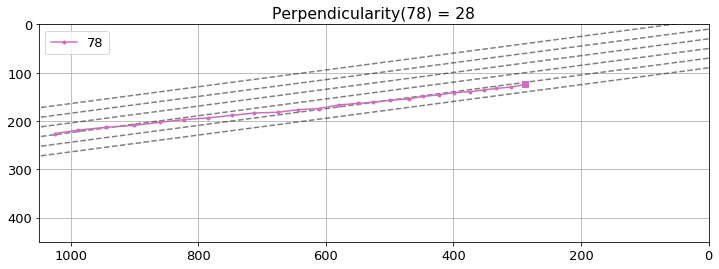

In [103]:
plt.figure(figsize=(8,3))

for i in range(40,131,30): # (-10,91,20):
    plt.plot(np.linspace(0, W, 100), slope*np.linspace(0, W, 100) + i, 'k--', alpha=0.5)

t.set_track_figure(FRAME_AREA)
bad_car['perpendicularity'] = np.random.choice(df.index, p=df.perpendicular_range.pow(4)/df.perpendicular_range.pow(4).sum())
car = bad_car['perpendicularity']
t.plot_track(X,Y,car)
plt.title(f"Perpendicular_range({car:s}) = {df.loc[car,'perpendicular_range']:.0f} pixels")
plt.legend();

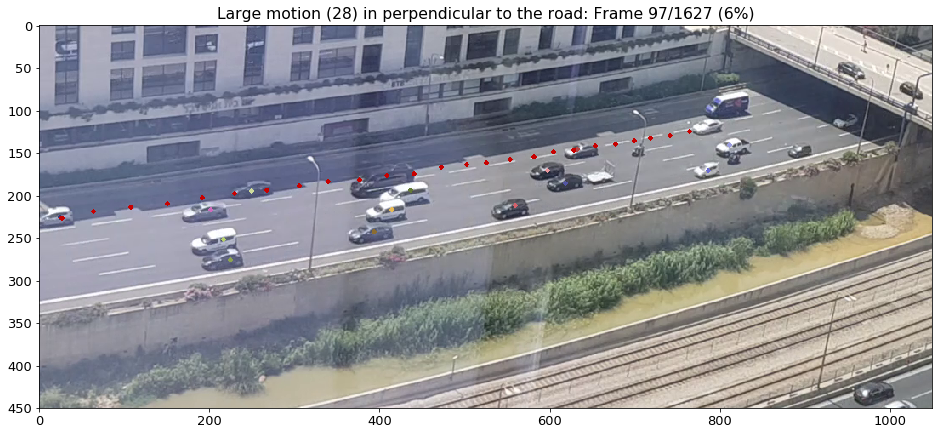

In [106]:
pr = df.loc[bad_car["perpendicularity"],"perpendicular_range"]
t.visualize_video(model, VIDEO_PATH, X, Y, car=bad_car['perpendicularity'], frame0=None, area=FRAME_AREA,
               boxes=False, dots=True, all_active_tracks=False, all_detections=False, self_track=30, extra_frames=0,
               display=2, save_frame=None, save_video=None,
               title=f'Large motion ({pr:.0f}) in perpendicular to the road')

# t.record_frame(videopath, X, Y, '5120', frm=15, self_track=4, display=False, to_save=OUT_PATH/'perp1a')
# t.record_frame(videopath, X, Y, '5120', frm=19, self_track=4, display=True, to_save=OUT_PATH/'perp1b')

## Driving Speed Analysis

Valid tracks:	252/288 (88%)


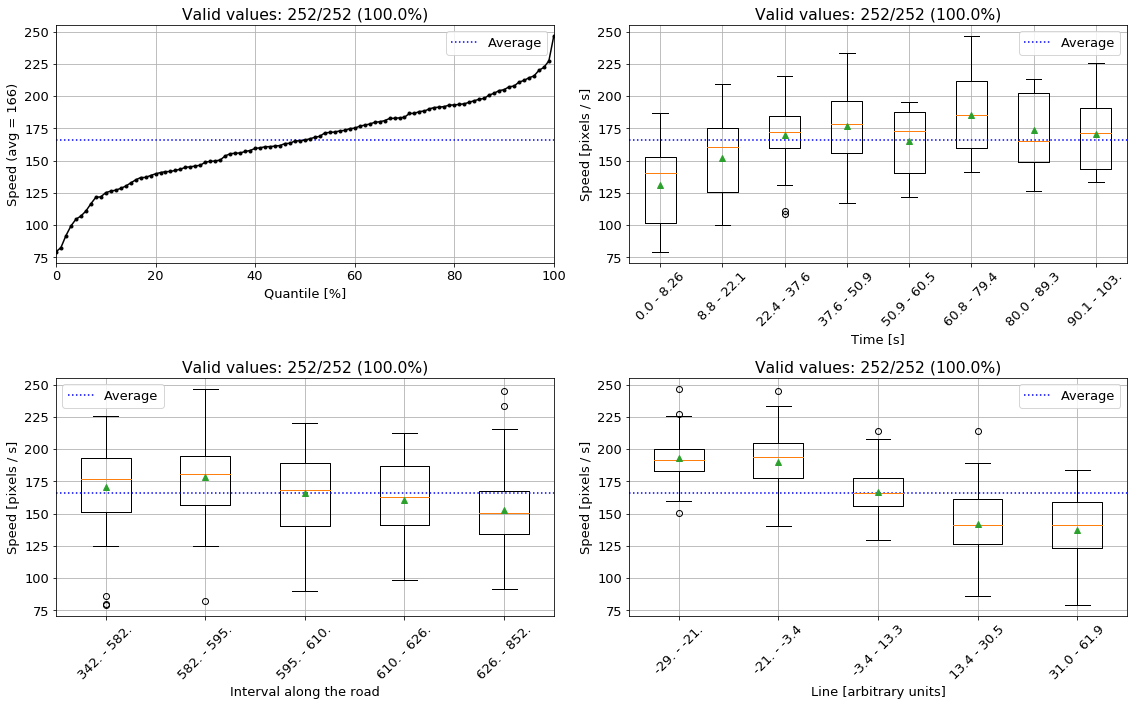

In [25]:
ids = df.loc[:,['consistent_xy_nas','valid_x_dir','valid_y_dir','valid_size','long_path']].all(axis=1)

print(f'Valid tracks:\t{ids.sum()}/{len(ids)} ({100*ids.mean():.0f}%)')

_, axs = plt.subplots(2,2, figsize=(16,10))
t.qplot(df.v[ids], ylab=f'Speed (avg = {df.v[ids].mean():.0f})', ax=axs[0,0])
t.boxplot_per_bucket(df.t0[ids], df.v[ids], n_buckets=8, xlab='Time [s]', ylab='Speed [pixels / s]', ax=axs[0,1])
t.boxplot_per_bucket((df.min_x[ids]+df.max_x[ids])/2, df.v[ids],
                     xlab='Interval along the road', ylab='Speed [pixels / s]', ax=axs[1,0])
t.boxplot_per_bucket(100-df.road_perpendicularity[ids], df.v[ids],
                     xlab='Line [arbitrary units]', ylab='Speed [pixels / s]', ax=axs[1,1])
plt.tight_layout()

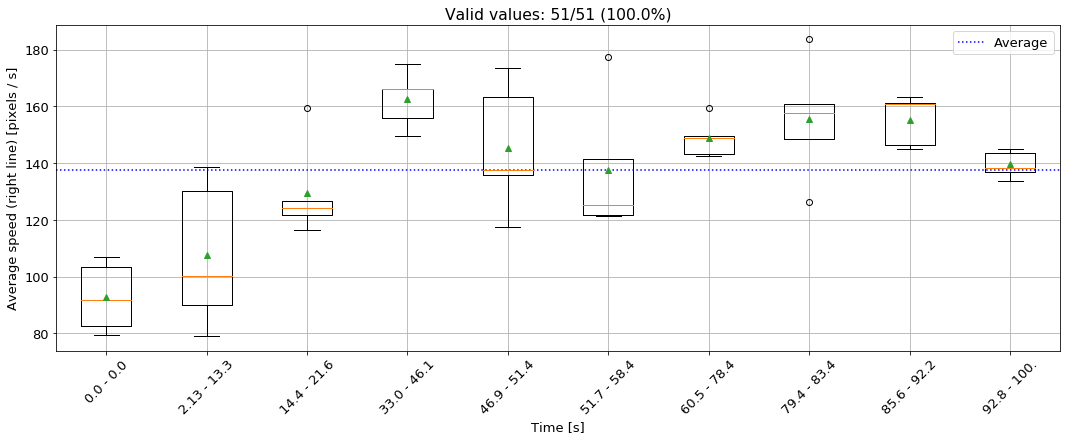

In [26]:
ids = df.loc[:,['consistent_xy_nas','valid_x_dir','valid_y_dir','valid_size','long_path']].all(axis=1)
ids = np.logical_and(ids, df.road_perpendicularity<np.percentile(df.road_perpendicularity[ids],20))

plt.figure(figsize=(18,6))
t.boxplot_per_bucket(df.t0[ids], df.v[ids], n_buckets=total_time//10,
                     xlab='Time [s]', ylab='Average speed (right line) [pixels / s]')

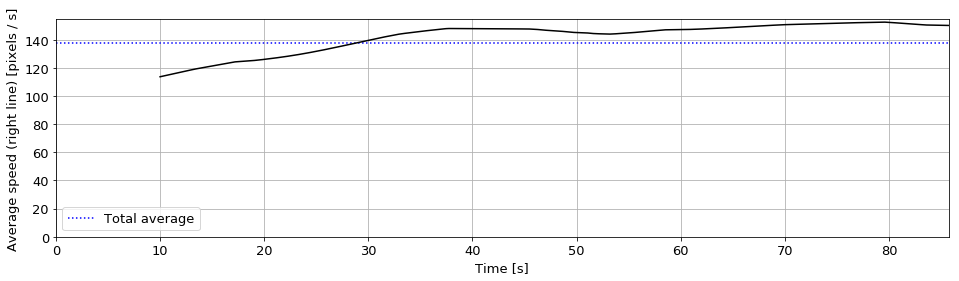

In [27]:
times = list(np.arange(10, df.t0.max()-20, 1/FPS))
decay = 10 # 1/e factor every "decay" seconds
ws = [np.exp(-np.abs(df[ids].t0-t)/decay) for t in times]
rolling_speed = [np.sum(w*df[ids].v)/np.sum(w) for w in ws]

_, axs = plt.subplots(1,1,figsize=(16,4))
ax = axs
ax.axhline(df[ids].v.mean(), color='blue', linestyle=':', label='Total average')
ax.plot(times, rolling_speed, 'k')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Average speed (right line) [pixels / s]')
ax.set_xlim((0,times[-1]))
ax.set_ylim((0,None))
ax.legend()
ax.grid()

In [28]:
ids = df.loc[:,['consistent_xy_nas','valid_x_dir','valid_y_dir','valid_size','long_path']].all(axis=1)

fastest = df[ids].v.idxmax()
slowest = df[ids].v.idxmin()

C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  after removing the cwd from sys.path.


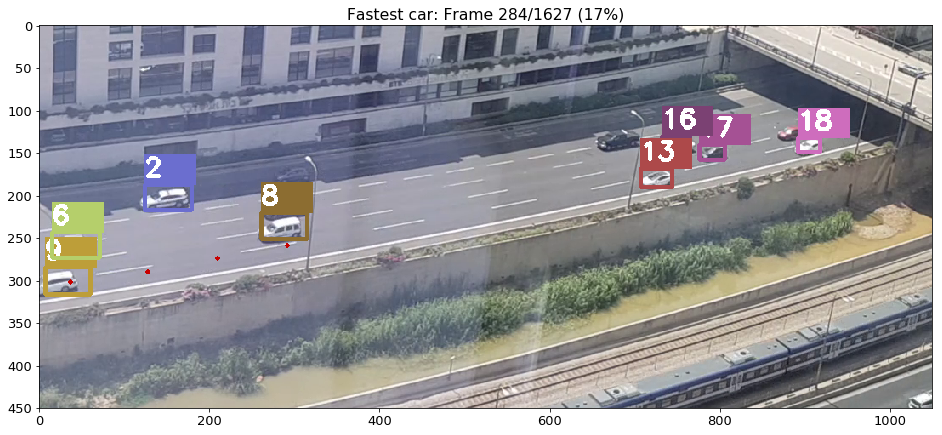

In [107]:
t.visualize_video(model, VIDEO_PATH, X, Y, car=fastest, frame0=None, area=FRAME_AREA,
               boxes=True, dots=False, all_active_tracks=False, all_detections=False, self_track=3, extra_frames=0,
               display=2, save_frame=None, save_video=None, title='Fastest car')

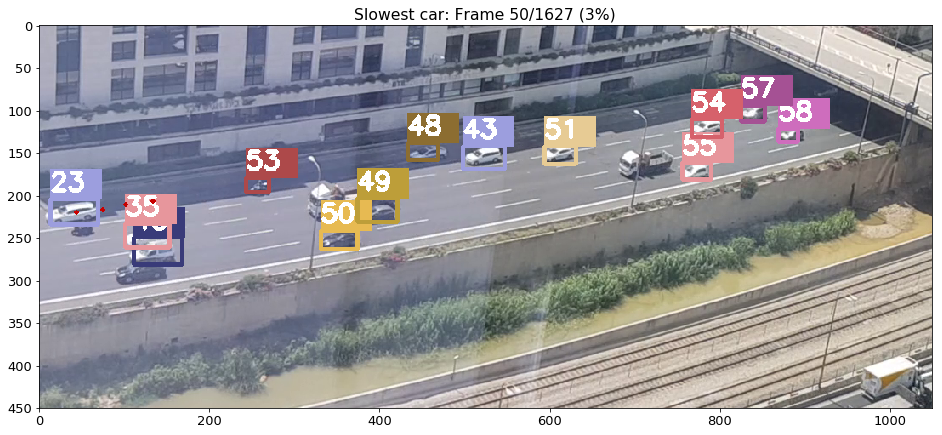

In [108]:
t.visualize_video(model, VIDEO_PATH, X, Y, car=slowest, frame0=None, area=FRAME_AREA,
               boxes=True, dots=False, all_active_tracks=False, all_detections=False, self_track=3, extra_frames=0,
               display=2, save_frame=None, save_video=None, title='Slowest car')

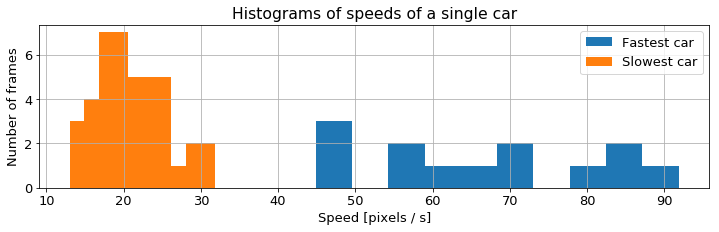

In [31]:
car = fastest
fast_speeds = np.power(np.power(X[car][X[car].notnull()].diff()[1:],2) + np.power(Y[car][Y[car].notnull()].diff()[1:],2),0.5) /\
              np.diff(np.array(X.index[X[car].notnull()])) * FPS

car = slowest
slow_speeds = np.power(np.power(X[car][X[car].notnull()].diff()[1:],2) + np.power(Y[car][Y[car].notnull()].diff()[1:],2),0.5) /\
              np.diff(np.array(X.index[X[car].notnull()])) * FPS

plt.figure(figsize=(12,3))
plt.hist(list(fast_speeds), label='Fastest car')
plt.hist(list(slow_speeds), label='Slowest car')
plt.xlabel('Speed [pixels / s]')
plt.ylabel('Number of frames')
plt.title('Histograms of speeds of a single car')
plt.grid()
plt.legend()
clear_output()

## Summary

### Anomalous trackings

Various errors and anomalous phenomena were observed in the original tracker, which applied IOU-based tracking on top of an out-of-the-box detection model. **The anomalies narrowed signficantly in presence of the dedicated likelihood-based tracker on top of a dedicatedly-trained detector**:

| Phenomenon | Before (easy video) | After (easy video) | After (hard video) |
| --- | --- | --- | --- |
| **Un-detected vehicles** | Estimated False-Negative of 40-80% of the vehicles in a frame | 5-10% | 10-20% |
| **Short tracks** | 50% of tracks shorter than 30% of the road | 25% of tracks shorter than 70% of the road | 80% of tracks shorter than 70% of the road |
| **Fake huge car detection** | 3% of tracks | None | None |
| **Motion against road direction** | 4% of tracks | None | 10-20%, most of them either short tracks (usually fake detections) or slight detection-fluctuations of nearly-standing cars |
| **Large motion in perpendicular to road** | 2% of the tracks seemed to follow fake perpendicular motion due to confusion in detection<->track assignment | most of the perpendicular motions are approved as actual car's lane-transition | ditto |

* Note: "easy video" means bright illumination, not-too-crowded traffic and no significant reflections from the window. "Hard video" means not easy.

### Speed analysis

- Speed varies between **lanes**. In particular, the rightest lanes are very slow.
- Speed varies a lot over **time**, without any clear periodicity.